## Improving classification with the AdaBoost meta-algorithm

- Pros: Low generalization error, easy to code, works with most classifiers, no parameters to adjust
- Cons: Sensitive to outliers
- Works with: Numeric values, nominal values

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Implement Adaboost

In [2]:
# Decision stump–generating functions
def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):
    retArray = np.ones(dataMatrix.shape[0])
    if threshIneq == 'lt':
        retArray[dataMatrix[:, dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:, dimen] > threshVal] = -1.0
    return retArray


# Set the minError to +Inf
# For every feature in the dataset:
#     For every step:
#         For each inequality:
#             Build a decision stump and test it with the weighted dataset
#             If the error is less than minError: set this stump as the best stump
# Return the best stump
def buildStump(dataMatrix, classLabels, D):
    numSteps = 10
    bestStump = {}
    bestClasEst = np.zeros(dataMatrix.shape[0])
    minError = np.inf
    for i in range(dataMatrix.shape[1]):
        rangeMin = dataMatrix[:, i].min()
        rangeMax = dataMatrix[:, i].max()
        stepSize = (rangeMax - rangeMin) / numSteps
        for j in range(-1, numSteps + 1):
            for inequal in ['lt', 'gt']:
                threshVal = rangeMin + j * stepSize
                predictedVals = stumpClassify(dataMatrix,
                                              i, threshVal, inequal)
                errArr = np.ones(dataMatrix.shape[0])
                errArr[predictedVals == classLabels] = 0
                # Calculate weighted error
                weightedError = np.dot(D, errArr)
                # print("split: dim %d, thresh %.2f, thresh ineqal: %s, "
                #       "the weighted error is %.3f"
                #       % (i, threshVal, inequal, weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump, minError, bestClasEst

In [3]:
# AdaBoost training with decision stumps
# For each iteration:
# Find the best stump using buildStump()
# Add the best stump to the stump array
# Calculate alpha
# Calculate the new weight vector – D
# Update the aggregate class estimate
# If the error rate ==0.0 : break out of the for loop
def adaBoostTrainDS(dataArr, classLabels, numIt=40):
    weakClassArr = []
    m = dataArr.shape[0]
    D = np.ones(m) / m
    aggClassEst = np.zeros(m)
    for i in range(numIt):
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)
        # print("D:", D)
        alpha = 0.5 * np.log((1.0 - error) / max(error, 1e-16))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        # print("classEst: ", classEst)
        # Calculate D for next iteration
        expon = np.multiply(-1 * alpha * classLabels, classEst)
        D = np.multiply(D, np.exp(expon))
        D = D / D.sum()
        # Aggregate error calculation
        aggClassEst += alpha * classEst
        # print("aggClassEst: ", aggClassEst)
        aggErrors = np.sign(aggClassEst) != classLabels
        errorRate = aggErrors.sum() / m
        # print("total error: ", errorRate)
        if errorRate == 0.0:
            break
    return weakClassArr, aggClassEst

In [4]:
# AdaBoost classification function
def adaClassify(dataMatrix, classifierArr):
    aggClassEst = np.zeros(dataMatrix.shape[0])
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'],
                                 classifierArr[i]['thresh'],
                                 classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha'] * classEst
        # print(aggClassEst)
    return np.sign(aggClassEst)

In [5]:
# ROC plotting and AUC calculating function
def plotROC(predStrengths, classLabels):
    cur = (1.0, 1.0)
    ySum = 0.0
    numPosClas = sum(classLabels == 1.0)
    yStep = 1 / numPosClas
    xStep = 1 / (len(classLabels) - numPosClas)
    # Get sorted index
    sortedIndicies = predStrengths.argsort()
    plt.figure()
    for index in sortedIndicies:
        if classLabels[index] == 1.0:
            delX, delY = 0, yStep
        else:
            delX, delY = xStep, 0
            ySum += cur[1]
        plt.plot([cur[0], cur[0] - delX], [cur[1], cur[1] - delY], c='b')
        cur = (cur[0] - delX, cur[1] - delY)
    plt.plot([0, 1], [0, 1], 'b--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    plt.axis([0, 1, 0, 1])
    plt.show()
    print("the Area Under the Curve is: ", ySum * xStep)

### Experiment 1: Toy dataset

In [6]:
def loadSimpData():
    datMat = np.array([[1., 2.1],
                       [2., 1.1],
                       [1.3, 1.],
                       [1., 1.],
                       [2., 1.]])
    classLabels = np.array([1.0, 1.0, -1.0, -1.0, 1.0])
    return datMat, classLabels

In [7]:
datArr, labelArr = loadSimpData()

In [8]:
classifierArr, _ = adaBoostTrainDS(datArr, labelArr, 30)
print(classifierArr)

[{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453}, {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565}, {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}]


In [9]:
adaClassify(np.array([[0, 0]]), classifierArr)

array([-1.])

In [10]:
adaClassify(np.array([[5, 5], [0, 0]]), classifierArr)

array([ 1., -1.])

### Experiment 2: Horse colic dataset

In [11]:
# Adaptive load data function
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split('\t')) - 1
    dataMat, labelMat = [], []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return np.array(dataMat), np.array(labelMat)

In [12]:
datArr, labelArr = loadDataSet('horseColicTraining2.txt')
classifierArray, _ = adaBoostTrainDS(datArr, labelArr, 10)
testArr, testLabelArr = loadDataSet('horseColicTest2.txt')
prediction10 = adaClassify(testArr, classifierArray)

In [13]:
(prediction10 != testLabelArr).sum() / len(testLabelArr)

0.23880597014925373

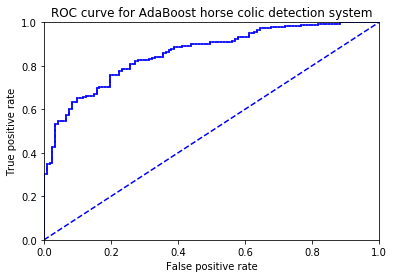

the Area Under the Curve is:  0.8582969635063604


In [14]:
classifierArray, aggClassEst = adaBoostTrainDS(datArr, labelArr, 10)
plotROC(aggClassEst.T, labelArr)